In [4]:
import sys
import os

os.chdir('code')
from cfn_model_generation import * 
os.chdir('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange


In [18]:
n_leaves = 1000 #Number of leafs on the tree
batch_size = 1000 #Number of spins per batch.
num_batches = 50 #Number of batches per tree
num_trees = 10 #Number of uniform trees in sample

trials_per_tree = batch_size * num_batches # Trials per tree
total_trials = trials_per_tree * num_trees # Total number of trials


delta = 1/10  #Value of delta. Theoretical max is delta = 1/924
C_val = .5 #C_{2.1} and C_{2.2}
c_val = 0.25 #c_{2.1} and c_{2.2}

C_upperTail = 4/5 * (9 * C_val**2 / (2*c_val) + 2* C_val)**2 #C_{2.7}
c_lowerTail = 1 - 2*c_val/(3*C_val) #c_{2.8}

probability_upper_tail_constant = 7*C_val #c_{2.7}
probability_lower_tail_constant = 78*C_val**2 #C_{2.8}

upper_tail_sample_threshold = 1 - C_upperTail* delta**2
lower_tail_sample_threshold = -c_lowerTail

upper_tail_probability = 1 - probability_upper_tail_constant*delta
lower_tail_probability = probability_lower_tail_constant * delta**2

print(f"The theoretical upper-tail bound is {upper_tail_probability:.4} and lower-tail bound is {lower_tail_probability:.4} for delta = {delta}.")

num_bins = max(500,int(10/delta))
bins = np.linspace(-1,1, num_bins+1)




The theoretical upper-tail bound is 0.65 and lower-tail bound is 0.195 for delta = 0.1.


In [3]:
Z = np.histogram([], bins)[0]
empircal_count_above_threshold = []
empircal_count_below_threshold = []

for tree in range(num_trees):
    print(f'Working on tree {tree+1}/{num_trees}.')
    empircal_count_above_threshold.append(0)
    empircal_count_below_threshold.append(0)
    root = UniformMagTree(n_leaves, delta, C_val = C_val, c_val = c_val)
    for i in trange(num_batches):
        attempt = root.constructMagnetization(batch_size)
        root.magnetizations = None

        empircal_count_above_threshold[-1] += sum(attempt >= upper_tail_sample_threshold)
        empircal_count_below_threshold[-1] += sum(attempt <= lower_tail_sample_threshold)

        binned_attempt = np.histogram(attempt, bins)[0]

        Z = Z+binned_attempt
    p_up = empircal_count_above_threshold[-1]/trials_per_tree
    p_down = empircal_count_below_threshold[-1]/trials_per_tree
    print(f"Proportion of samples above upper threshold {p_up}.")
    print(f"Proportion of samples above upper threshold {p_down}.")
    


Working on tree 1/10.


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


Proportion of samples above upper threshold [0.91342].
Proportion of samples above upper threshold [0.0069].
Working on tree 2/10.


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Proportion of samples above upper threshold [0.89158].
Proportion of samples above upper threshold [0.0099].
Working on tree 3/10.


100%|██████████| 50/50 [00:25<00:00,  1.92it/s]


Proportion of samples above upper threshold [0.89996].
Proportion of samples above upper threshold [0.01048].
Working on tree 4/10.


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Proportion of samples above upper threshold [0.90218].
Proportion of samples above upper threshold [0.00804].
Working on tree 5/10.


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


Proportion of samples above upper threshold [0.92212].
Proportion of samples above upper threshold [0.00696].
Working on tree 6/10.


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Proportion of samples above upper threshold [0.9118].
Proportion of samples above upper threshold [0.0077].
Working on tree 7/10.


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Proportion of samples above upper threshold [0.89478].
Proportion of samples above upper threshold [0.01006].
Working on tree 8/10.


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Proportion of samples above upper threshold [0.92198].
Proportion of samples above upper threshold [0.00588].
Working on tree 9/10.


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Proportion of samples above upper threshold [0.91204].
Proportion of samples above upper threshold [0.00804].
Working on tree 10/10.


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]

Proportion of samples above upper threshold [0.91486].
Proportion of samples above upper threshold [0.0074].


In [17]:
print(sum(empircal_count_above_threshold)/total_trials)
print(sum(empircal_count_below_threshold)/total_trials)

[0.908472]
[0.008136]


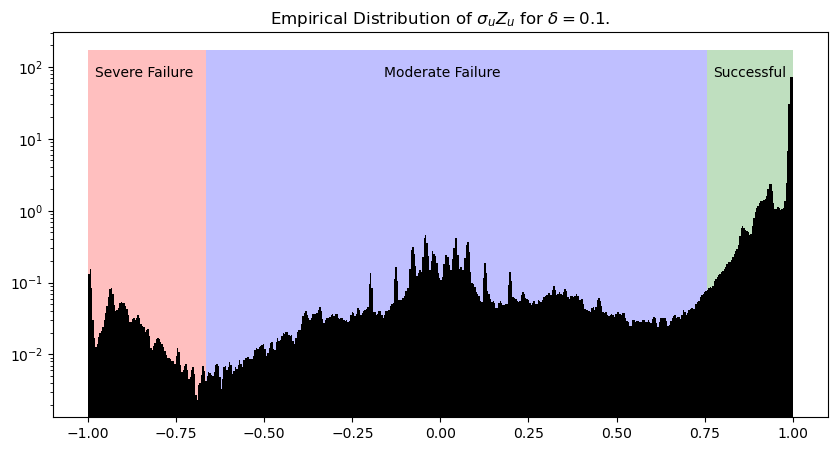

In [9]:
gap = bins[1]-bins[0]

smoothed_out_histogram = np.hstack((0,Z[:-1]))+np.hstack((Z[1:], 0)) + 2*Z
smoothed_out_histogram = smoothed_out_histogram/sum(smoothed_out_histogram)*(1/gap)

A = max(smoothed_out_histogram)+100
B = A - 100

fig, ax = plt.subplots(figsize = (10,5))

alpha = 0.25
ax.stairs([A],[lower_tail_sample_threshold,upper_tail_sample_threshold], fill = True, color = 'blue', alpha = alpha)
ax.stairs([A], [upper_tail_sample_threshold,1],fill = True, color = 'g', alpha = alpha)
ax.stairs([A], [-1,lower_tail_sample_threshold],fill = True, color = 'r', alpha = alpha )
ax.stairs(smoothed_out_histogram, bins, fill = True, color = 'k')
ax.annotate('Severe Failure', xy = (-.98,B))
ax.annotate('Moderate Failure', xy = (-.16,B))
ax.annotate('Successful', xy = (.775,B))

plt.title(f"Empirical Distribution of $\\sigma_u Z_u$ for $\\delta = ${delta:.2}.")
plt.yscale('log')
plt.savefig("images/image1/image1.png",dpi = 500)

df = {'bins':bins, 'histogram':list(Z)+[None]}
df = pd.DataFrame(df)
df.to_csv('images/image1/data.csv', index = False)

with open('images/image1/notes.txt', 'w') as f:
    f.write(f'The number of leaves: {n_leaves}\n')
    f.write(f'The number of samples in each batch: {batch_size}\n')
    f.write(f'The number of batches per tree: {num_batches}\n')
    f.write(f'The number of trees: {num_trees}\n')
    f.write(f'Delta was set at {delta}.\n')
    f.write(f'Constants are as in the paper, except for delta.')
    
    




In [10]:
n_leaves = 200
n_trees = 5
errors =[]
epochs = 3
for t in range(n_trees):
    tree, _,_,_ = UniformTree(n_leaves,batch_size, delta, warmStart=False, C_val = C_val, c_val = c_val)
    error = np.array([tree.get_gaps([1,2])]).reshape(-1,1)
    
    for i in range(epochs):
        error = np.hstack((error, np.array(tree.update_round([1,2]))))
    errors.append(error)

Round 1 progress:


100%|██████████| 399/399 [01:19<00:00,  5.04it/s]


Round 2 progress:


100%|██████████| 399/399 [01:16<00:00,  5.19it/s]


Round 3 progress:


100%|██████████| 399/399 [01:15<00:00,  5.25it/s]


Round 1 progress:


100%|██████████| 399/399 [01:20<00:00,  4.94it/s]


Round 2 progress:


100%|██████████| 399/399 [01:18<00:00,  5.05it/s]


Round 3 progress:


100%|██████████| 399/399 [01:16<00:00,  5.24it/s]


Round 1 progress:


100%|██████████| 399/399 [01:14<00:00,  5.32it/s]


Round 2 progress:


100%|██████████| 399/399 [01:18<00:00,  5.10it/s]


Round 3 progress:


100%|██████████| 399/399 [01:16<00:00,  5.19it/s]


Round 1 progress:


100%|██████████| 399/399 [01:18<00:00,  5.11it/s]


Round 2 progress:


100%|██████████| 399/399 [01:16<00:00,  5.19it/s]


Round 3 progress:


100%|██████████| 399/399 [01:17<00:00,  5.16it/s]


Round 1 progress:


100%|██████████| 399/399 [01:15<00:00,  5.31it/s]


Round 2 progress:


100%|██████████| 399/399 [01:16<00:00,  5.23it/s]


Round 3 progress:


100%|██████████| 399/399 [01:17<00:00,  5.18it/s]


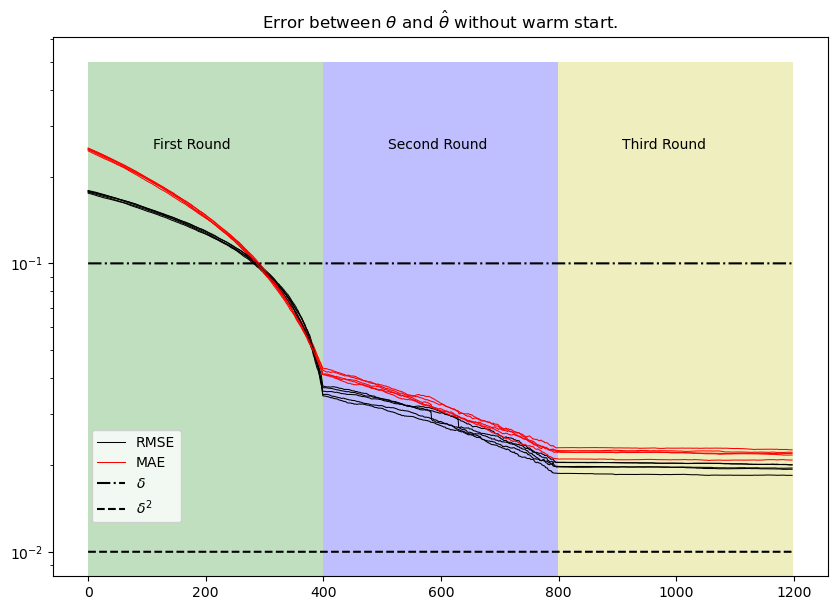

In [14]:
t = list(range(len(error[1,:])))
t1 = [0, len(t)//3+1]
t2 = [len(t)//3+1, 2*len(t)//3+1]
t3 = [2*len(t)//3+1, len(t)]
fig, ax = plt.subplots(figsize = (10,7))
A = 1/2
alpha = .25
ax.stairs([A], t1, fill = True, color = 'g', alpha = alpha)
ax.stairs([A], t2, fill = True, color = 'b', alpha = alpha)
ax.stairs([A], t3, fill = True, color = 'y', alpha = alpha)
linewidth = .75
for i, e in enumerate(errors):
    if i==0:
        plt.plot(t, e[1,:]/np.sqrt(n_leaves), 'k', label = 'RMSE', linewidth = linewidth)
        plt.plot(t, e[0,:]/n_leaves, 'r', label = 'MAE', linewidth = linewidth)
    else:
        plt.plot(t, e[1,:]/np.sqrt(n_leaves), 'k', linewidth = linewidth)
        plt.plot(t, e[0,:]/n_leaves, 'r', linewidth = linewidth)
plt.plot(t, [delta for _  in t],'k', ls = '-.', label = '$\\delta$')
plt.plot(t, [delta**2 for _  in t], 'k--',label = '$\\delta^2$')

x1,x2,x3 = np.mean(t1), np.mean(t2), np.mean(t3)
offset = 90
x1, x2, x3 = x1-offset, x2-offset, x3-offset
ax.annotate('First Round', xy = (x1,A/2))
ax.annotate('Second Round', xy = (x2,A/2))
ax.annotate('Third Round', xy = (x3,A/2))
plt.title("Error between $\\theta$ and $\\hat{\\theta}$ without warm start.")
plt.yscale('log')
plt.legend(loc = (.05,.1))
plt.savefig('images/image1/coordinate_update.png',dpi = 500)
plt.show()